# Financial Forecasting with LSTM and TensorFlow

## Import Necessary Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from keras.utils import plot_model
from time import time

%matplotlib inline

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# Encode a column to a range between normalized_low and normalized_high.
def normalize(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Encode a column to a range between normalized_low and normalized_high.
def denormalize(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = df[name] * (data_high - data_low) + data_low

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Attain Financial Datasets

In [ ]:
df = pd.read_csv('TLKM.JK.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   int64  
 2   High       1259 non-null   int64  
 3   Low        1259 non-null   int64  
 4   Close      1259 non-null   int64  
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 69.0+ KB


In [ ]:
# df.tail()

Text(0, 0.5, 'price')

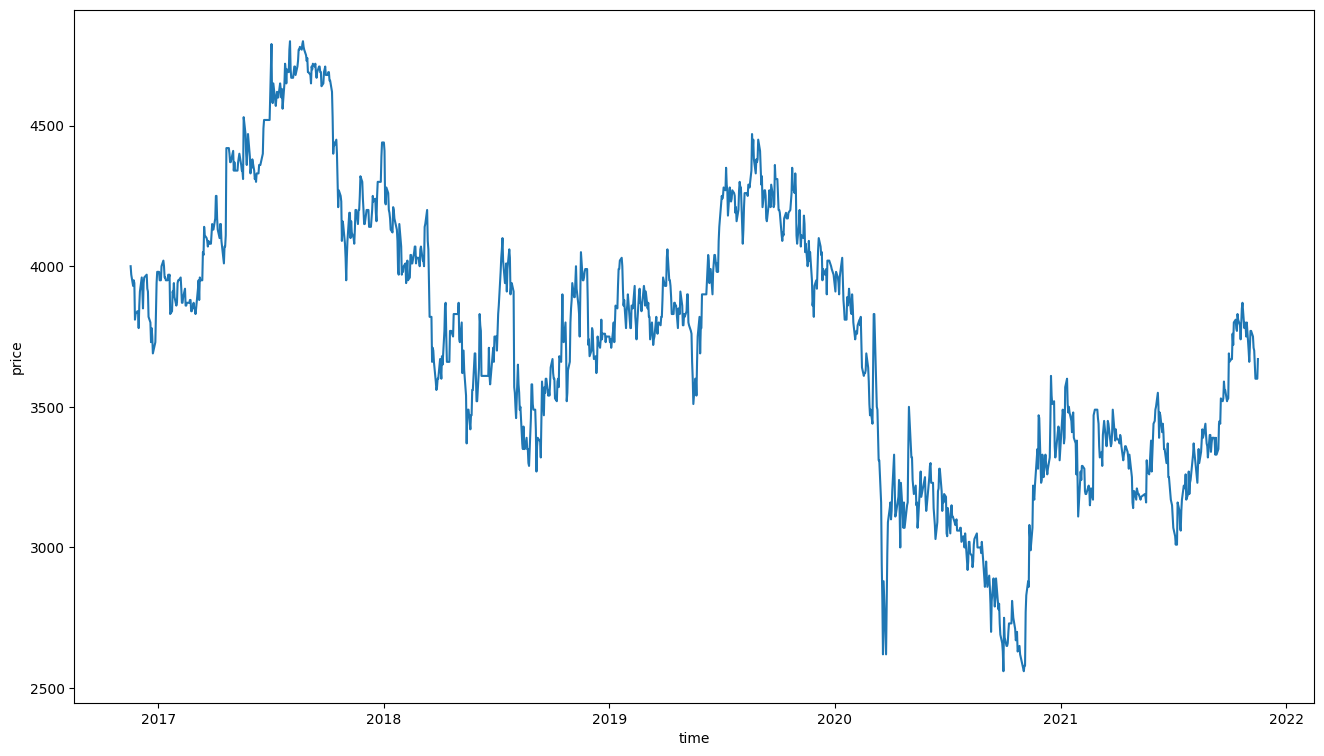

In [ ]:
df.isnull().count()
df['Date'] = pd.to_datetime(df['Date'].astype('datetime64[ns]'))
df['Close'] = df['Close'].astype(int)

plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df['Date'])
plt.xlabel('time')
plt.ylabel('price')

In [ ]:
stock = df['Close'].to_numpy()
print(stock.shape, stock.size)
stock

(1259,) 1259


array([4000, 3970, 3930, ..., 3600, 3600, 3670])

##Feature important

In [ ]:
x = df[['Open', 'Low', 'High', 'Volume']]
y = df['Close']
print(x.shape, y.shape)

x

(1259, 4) (1259,)


,Open,Low,High,Volume
0,3950,3950,4040,84236700
1,4020,3960,4030,98115300
2,3950,3920,3970,82463000
3,3920,3910,3970,69602800
4,3930,3920,3970,108352600
...,...,...,...,...
1254,3670,3670,3720,53511200
1255,3700,3640,3730,95789600
1256,3660,3600,3660,115142400
1257,3600,3600,3650,91001800


Feature: 0, Score: -0.5796
Feature: 1, Score: 0.7692
Feature: 2, Score: 0.8132
Feature: 3, Score: -0.0000


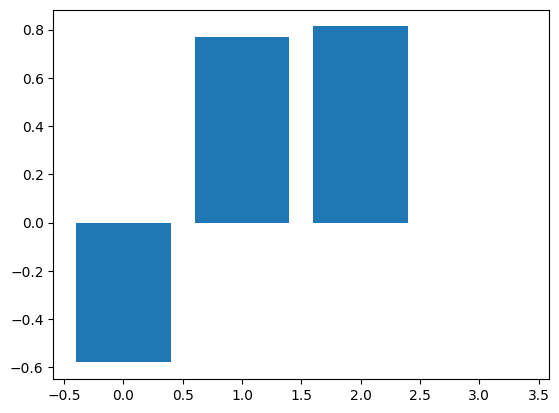

In [ ]:
# define the model
model = LinearRegression()
# fit the model
model.fit(x, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.4f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.00092
Feature: 1, Score: 0.21574
Feature: 2, Score: 0.78193
Feature: 3, Score: 0.00141


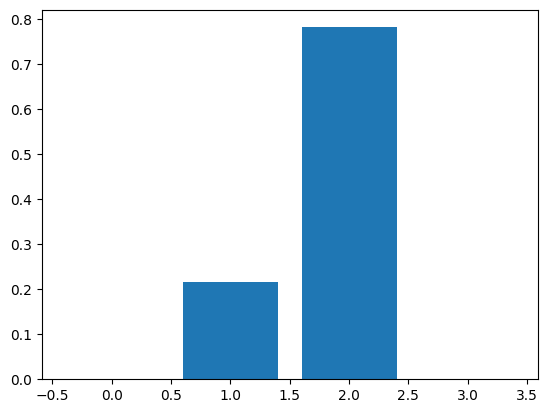

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(x, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.00107
Feature: 1, Score: 0.49076
Feature: 2, Score: 0.50714
Feature: 3, Score: 0.00104


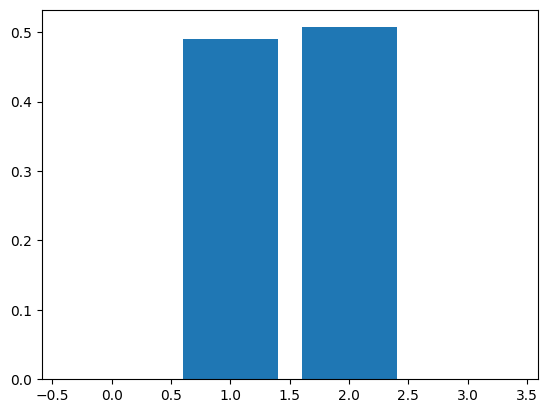

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(x, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
from xgboost import XGBRegressor
# define the model
model = XGBRegressor()
# fit the model
model.fit(x, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00060
Feature: 1, Score: 0.46145
Feature: 2, Score: 0.53741
Feature: 3, Score: 0.00054


PWe can attain a total of 5670 data points from AALI.

## Visualize Data


In [ ]:
df['Date'] = pd.to_datetime(df['Date'].astype('datetime64[ns]'))
data = df.set_index('Date')

data['Week']=data.index.week
data['Month']=data.index.month
data['Year']=data.index.year
data = data.reset_index()
data.head()

<ipython-input-18-b0cd529badf9>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['Week']=data.index.week


,Date,Open,High,Low,Close,Adj Close,Volume,Week,Month,Year
0,2016-11-17,3950,4040,3950,4000,3431.399658,84236700,46,11,2016
1,2016-11-18,4020,4030,3960,3970,3405.663818,98115300,46,11,2016
2,2016-11-21,3950,3970,3920,3930,3371.350098,82463000,47,11,2016
3,2016-11-22,3920,3970,3910,3950,3388.507080,69602800,47,11,2016
4,2016-11-23,3930,3970,3920,3940,3379.928467,108352600,47,11,2016


In [ ]:
# wise = data.groupby(['Week', pd.Grouper(key='Year')])
# yearwise = data.groupby(['Year'])
# monthwise = data.groupby(['Month', pd.Grouper(key='Year')])

# for name, group in wise:
#   print(name)
#   print(group)
#   print('\n')

In [ ]:
# for name, group in wise:

#   group.plot(x='Date', y='Close', label=name)

In [ ]:
# for name, group in yearwise:

#   group.plot(x='timestamp', y='close', label=name)

In [ ]:
# for name, group in monthwise:

#   group.plot(x='timestamp', y='close', label=name)

In [ ]:
df(['Date']>='2021').plot()

In [ ]:
# df2['month']=df2.index.month #buat tabel tambahan bulan
# ans = [pd.DataFrame(y, columns=df2.columns.difference(['month'])) for x, y in df2.groupby('month')] ##grup berdasarkan bulan dan hapus kolom bulan

In [ ]:
#plot seasonal
# df['timestamp'] = pd.to_datetime(df['timestamp'].astype('datetime64[ns]'))
# df1 = df.set_index('timestamp')
# df1= df1[['close']].copy()
# result = seasonal_decompose(df1, model='additive')

# # # print(result.seasonal)
# plt.figure(figsize=(16, 9))
# result.plot()
# plt.show()

In [ ]:
#plot seasonal
# from statsmodels.tsa.seasonal import seasonal_decompose

# df2 = pd.read_csv('/content/AALI20233.csv')
# df2['timestamp'] = pd.to_datetime(df['timestamp'].astype('datetime64[ns]'))
# df2 = df2.set_index('timestamp')
# # df2.plot()
# # df2.head

# result = seasonal_decompose(df2, model='additive')

# # print(result.seasonal)
# result.seasonal.plot()
# plt.show()

In [ ]:
# Approach 1: Check duplicate
# boolean = df.duplicated(subset=['timestamp']).any()
# print(boolean, end='\n\n') # True

# # Approach 2: First store boolean array, check then remove
# duplicate_in_student = df.duplicated(subset=['Student'])
# if duplicate_in_student.any():
#     print(df.loc[~duplicate_in_student], end='\n\n')

In [ ]:
#Plot data

# df.plot(x='timestamp', y='close', subplots=True, grid=False, figsize=(12, 7), fontsize=12)
# plt.xlabel('timestamp', fontsize=12)
# plt.ylabel('Price', fontsize=12)

# # mlt.savefig('data.png')
# # files.download("data.png")

# plt.show()

In [ ]:
#density
# sns.distplot(stock)

In [ ]:
#boxplot or see outlier

# df.boxplot(column='close')
# plt.show()

In [ ]:
# df.isna().sum()

In [ ]:
#scatter plot

# plt.figure(figsize=[15,10])
# plt.scatter(df['close'], y=df['open']);
# # plt.grid(True)
# # # plt.title('Stock open and close \n01-01-2012 to 31-12-2020', fontsize=14, color='black')
# # plt.xlabel("Open Price",fontsize=12, color='black')
# # plt.ylabel("Close price", fontsize=12, color='black')
# plt.show()

##Sliding Window

In [ ]:
# choose a number of time steps
n_steps = 4
# split into samples
x, y = split_sequence(stock, n_steps)
# summarize the data
# for i in range(5):
#  print(x[i], y[i])

print("x train shape : ", x.shape, "\ny train shape : ", y.shape)

x train shape :  (1255, 4) 
y train shape :  (1255,)


## Split Testing and Training Datasets

In [ ]:
#split data into training and testing
x_train, x_val, x_test = \
      np.split(x, [int(.8*len(x)), int(.9*len(x))])

y_train, y_val, y_test = \
      np.split(y, [int(.8*len(y)), int(.9*len(y))])

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
# print(y_test)

(1004, 4) (125, 4) (126, 4)
(1004,) (125,) (126,)


**Note to self:**

For train_test_split, the first data param is for x variables (so we remove the 'Close' column) and the second is for the y varibles (hence we use the 'Close' column).

##Reshape input

In [ ]:
# # reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1

x_train = x_train.reshape((x_train.shape[0], n_steps, n_features))
x_val = x_val.reshape((x_val.shape[0], n_steps, n_features))
x_test = x_test.reshape((x_test.shape[0], n_steps, n_features))

print(x_train.shape, x_val.shape, x_test.shape)
# print(x_test)

(1004, 4, 1) (125, 4, 1) (126, 4, 1)


## Build Model

In [ ]:
do_rate = 0.01
hidden_node = 50
lr = 0.01
batch_size = 10
epoch = 50

In [ ]:
# define model
modelA = Sequential()
modelA.add(LSTM(hidden_node, activation='relu', input_shape=[n_steps, n_features]))
# modelA.add(Dropout(0.01))
modelA.add(Dense(1))
modelA.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# define model
modelB = Sequential()
modelB.add(LSTM(hidden_node, activation='relu', input_shape=[n_steps, n_features]))
modelB.add(Dropout(0.01))
modelB.add(Dense(1))
modelB.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# define model
modelC = Sequential()
modelC.add(LSTM(hidden_node, activation='relu', input_shape=[n_steps, n_features]))
modelC.add(Dropout(0.1))
modelC.add(Dense(1))
modelC.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# define model
modelD = Sequential()
modelD.add(LSTM(hidden_node, activation='relu', input_shape=[n_steps, n_features]))
modelD.add(Dropout(0.3))
modelD.add(Dense(1))
modelD.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# plot_model(model,
#           to_file="model.png",
#           show_shapes=True)

In [ ]:
loss = tf.keras.losses.Huber()
metrics = tf.keras.metrics.RootMeanSquaredError()

In [ ]:
# modelA.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=[metrics])
modelB.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=[metrics])
modelC.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=[metrics])
modelD.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=[metrics])

# Create a checkpoint based on val_loss
checkpoint = ModelCheckpoint("my_checkpoint.h5", save_best_only=True,
                             monitor='val_loss')

## Fit Model

In [ ]:
start = time()
# fit model
historyA = modelA.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epoch,
                    validation_data=(x_val, y_val),
                    verbose=0)

# print(time()-start)

In [ ]:
start = time()
# fit model
historyB = modelB.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epoch,
                    validation_data=(x_val, y_val),
                    verbose=0)

print(time()-start)

In [ ]:
start = time()
# fit model
historyC = modelC.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epoch,
                    validation_data=(x_val, y_val),
                    verbose=0)

print(time()-start)

In [ ]:
start = time()
# fit model
historyD = modelD.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epoch,
                    validation_data=(x_val, y_val),
                    verbose=0)

print(time()-start)

In [ ]:
# for key in history.history:
#   print(key)

In [ ]:
# evaluate the model
_, train_mse = model.evaluate(x_train, y_train, verbose=0)
_, val_mse = model.evaluate(x_val, y_val, verbose=0)

print('Train: %.3f, Val: %.3f' % (train_mse, val_mse))

In [ ]:
# Get training and test loss histories
# training_lossA = historyA.history['loss']
training_lossB = historyB.history['loss']
training_lossC = historyC.history['loss']
training_lossD = historyD.history['loss']
test_lossB = historyB.history['val_loss']
# Create count of the number of epochs
epoch_count = range(1, len(training_lossB) + 1)

# # plot loss during training
# plt.plot(epoch_count, training_lossA, 'r--')
plt.plot(epoch_count, training_lossB, 'r--')
plt.plot(epoch_count, test_lossB, 'b-')
plt.legend(['train', 'loss'])
plt.title(['DO 0.01'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
plt.plot(epoch_count, training_lossC, 'r--')
plt.plot(epoch_count, test_lossB, 'b-')
plt.title(['DO 0.1'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
plt.plot(epoch_count, training_lossD, 'r--')
plt.plot(epoch_count, test_lossB, 'b-')
plt.title(['DO 0.3'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Evaluate

In [ ]:
yhatA = modelA.predict(x_test)
yhatB = modelB.predict(x_test)
yhatC = modelC.predict(x_test)
yhatD = modelD.predict(x_test)
# yhat.shape

In [ ]:
rmse = sqrt(mean_squared_error(y_test, yhat))
# rmse_persen = (rmse / np.mean(y_test)) * 100
# print('Test RMSE : %.3f' % rmse, " atau ", f"{rmse_persen:.2f}%")
print('Test RMSE : %.3f' % rmse)
print("R2 score  :",r2_score(y_test, yhat))
print("MAPE : ", mean_absolute_percentage_error(y_test, yhat))

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(y_test, 'r-', label='Actual')
# plt.plot(yhat, label='Prediction')
plt.plot(yhatB, label='DO O.01')
plt.plot(yhatC, label='DO 0.1')
plt.plot(yhatD, label='DO 0.3')
plt.legend()
plt.show()

In [ ]:
# Make predictions for the next 10 days
lw = x[-1]
lwo = lw.reshape(1, n_steps, n_features)

predictions = []
for _ in range(5):
    pred = model.predict([lwo])
    pred.resize(1)
    predictions.append(pred[0])
lw = np.concatenate((lw[1:], pred), axis=0)

In [ ]:
lw.shape

In [ ]:
predictions

In [ ]:
# Print the predicted values for the next 30 days
print("Predicted Prices for the Next 10 Days:")
for i, prediction in enumerate(predictions):
    print(f"Day {i+1}: {prediction:.2f}")

In [ ]:
# organize the results in a data frame
# df = pd.DataFrame(df, columns=['close'])
# df_past = df[['close']].reset_index()
df.rename(columns={'close': 'Actual'}, inplace=True)
# df_past['Date'] = pd.to_datetime(df_past['Date'])
df['Forecast'] = np.nan
df['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Actual', 'Forecast'])
df_future = pd.date_range(start=df.iloc[-1] + pd.Timedelta(days=1), periods=1)
df_future['Forecast'] = xhat.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='AAPL')

In [ ]:
import numpy as np

y = df['close']
# y = y.reshape(-1, 1)

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30 # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.asarray(X)
Y = np.asarray(Y)

print(X.shape, Y.shape)

In [ ]:
# fit the model
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=10, batch_size=32, verbose=0)

In [ ]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = np.array(X_)
X_ = np.reshape(X_, (1, n_lookback, 1))

Y_ = model.predict(X_)
# Y_ = scaler.inverse_transform(Y_)

print(X_.shape, Y_.shape)
# print(X_)

In [ ]:
# organize the results in a data frame
df = pd.DataFrame(y, columns=['close'])
df_past = df[['close']].reset_index()
df_past.rename(columns={'index': 'Date', 'close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=1)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='AAPL')

In [ ]:
test_data = stock[5102:]
n_test = int(len(test_data) / 4)
x_test = test_data.reshape((n_test, n_seq, n_steps, n_features))
print(test_data.shape, x_test.shape)

In [ ]:
pred.shape

In [ ]:
yhat = model.predict(x_test, verbose=0)
yhat.shape

Let's see if we have successfully split the datasets.

The datasets have been split into **8:2 ratio**, and we also notice that **x-datasets have 4 columns** for 'Open', 'High', 'Low', and 'Volume', and **y-datasets have just one column**, which is the target 'Close' column.